# Литература

* Увеличение чувствительности A/Б-тестов с помощью Cuped. Доклад в Яндексе
[статья](https://habr.com/ru/companies/yandex/articles/497804/)
[видео](https://www.youtube.com/watch?v=pZpUM08mv-E)

* [Как улучшить ваши A/B-тесты: лайфхаки аналитиков Авито. Часть 2](https://habr.com/ru/companies/avito/articles/571096/)

In [67]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [68]:
sns.set_theme(context='notebook', 
                  style='darkgrid', 
                  palette='deep',
                  font='sans-serif', 
                  font_scale=1, 
                  color_codes=True, 
                  rc=None)

In [99]:
def generate_data(sample_size, corr):
    """Генерируем две выборки с случайным сэмплированием.
    
    sample_size - размер выборки
    corr - корреляция метрики во время эксперимента с метрикой до эксперимента
    
    return - pd.DataFrame со столбцами ['metric', 'metric_before', 'factor'],
        'metric' - значение метрики во время эксперимента,
        'metric_before' - значение метрики до время эксперимента.
    """
    means = [5, 5]
    cov = [[1, corr], [corr, 1]]
    data = np.random.multivariate_normal(means, cov, sample_size)
    df = pd.DataFrame({'metric': data[:, 0], 'metric_before': data[:, 1]})
    return df

In [56]:
def calculate_theta(y_control, y_pilot, x_control, x_pilot):
    """Вычисляем Theta по данным двух групп.

    y_control - значения метрики во время пилота на контрольной группе
    y_pilot - значения метрики во время пилота на пилотной группе
    x_control - значения ковариант на контрольной группе
    x_pilot - значения ковариант на пилотной группе
    """
    y = np.hstack([y_control, y_pilot])
    x = np.hstack([x_control, x_pilot])
    covariance = np.cov(x, y)[0, 1]
    variance = x.var()
    theta = covariance / variance
    return theta

In [57]:
def check_test(df_control, df_test):
    """Проверяет гипотезу о равенстве средних с помощью t-test.

    return - pvalue.
    """
    values_control = df_control['metric'].values
    values_test = df_test['metric'].values
    _, pvalue = stats.ttest_ind(values_control, values_test)
    return pvalue


def check_cuped_test(df_control, df_test, covariate_column):
    """Проверяет гипотезу о равенстве средних с использованием CUPED.

    covariate_column - название стобца с ковариантой

    return - pvalue.
    """
    theta = calculate_theta(
        df_control['metric'], df_test['metric'],
        df_control[covariate_column], df_test[covariate_column]
    )
    metric_cuped_control = df_control['metric'] - theta * df_control[covariate_column]
    metric_cuped_test = df_test['metric'] - theta * df_test[covariate_column]
    _, pvalue = stats.ttest_ind(metric_cuped_control, metric_cuped_test)
    return pvalue

In [58]:
def plot_hist_and_ecdf(p_values, add_hline=False):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    sns.histplot(p_values, ax=ax1, alpha=0.5, bins = 20, stat='density')
    ax1.plot([0, 1], [1, 1], 'k--')
    ax1.set(xlabel='p-value', ylabel='Density')

    # empirical cumulative distribution functions
    sns.ecdfplot(p_values, ax=ax2, stat='proportion')
    ax2.plot([0, 1], [0, 1], 'k--')
    ax2.set(xlabel='p-value', ylabel='Probability')
    if add_hline:
        ax2.plot([0.05, 0.05], [0, 1], 'k-', alpha=0.5)   

In [94]:
sample_size = 1000
corr = 0.6

In [95]:
p_values = []
for _ in range(1000):
    df_control = generate_data(sample_size, corr)
    df_test = generate_data(sample_size, corr)
   
    p_values.append(check_cuped_test(df_control, df_test, covariate_column='metric_before'))

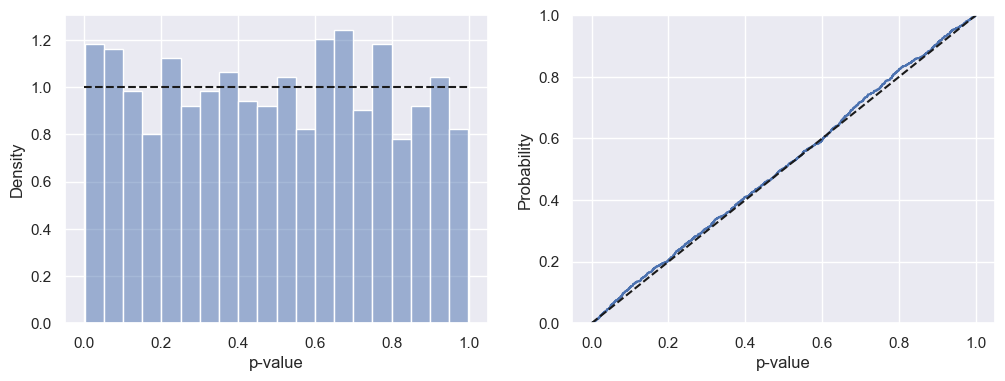

In [96]:
plot_hist_and_ecdf(p_values, add_hline=False)

In [97]:
p_values = []
for _ in range(1000):
    df_control = generate_data(sample_size, corr)
    df_test = generate_data(sample_size, corr)
    df_test['metric'] = df_test['metric'] + np.random.normal(loc=0.1, scale=0.01, size=sample_size)
    
    p_values.append(check_cuped_test(df_control, df_test, covariate_column='metric_before'))

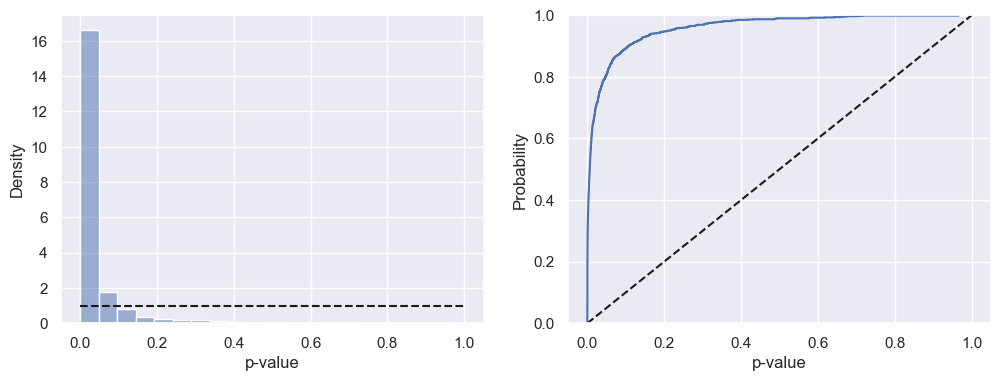

In [98]:
plot_hist_and_ecdf(p_values, add_hline=False)

In [118]:
mean_one = 0
mean_two = 2
std_one = 1
std_two = 1
weights = {0: 0.5, 1: 0.5}
sample_size = 1000

pvalues = []
pvalues_cuped = []

for _ in range(3000):
    df_control = generate_data(sample_size, corr=0.5)
    df_test = generate_data(sample_size, corr=0.5)

#   add eff
    effect = np.random.normal(0.1, 0.05, sample_size)
    df_test['metric'] += effect
    
    pvalues.append(check_test(df_control, df_test))
    pvalues_cuped.append(check_cuped_test(df_control, df_test, covariate_column='metric_before'))

list_pvalues = [pvalues, pvalues_cuped]
list_titles = ['ttest', 'cuped_ttest']

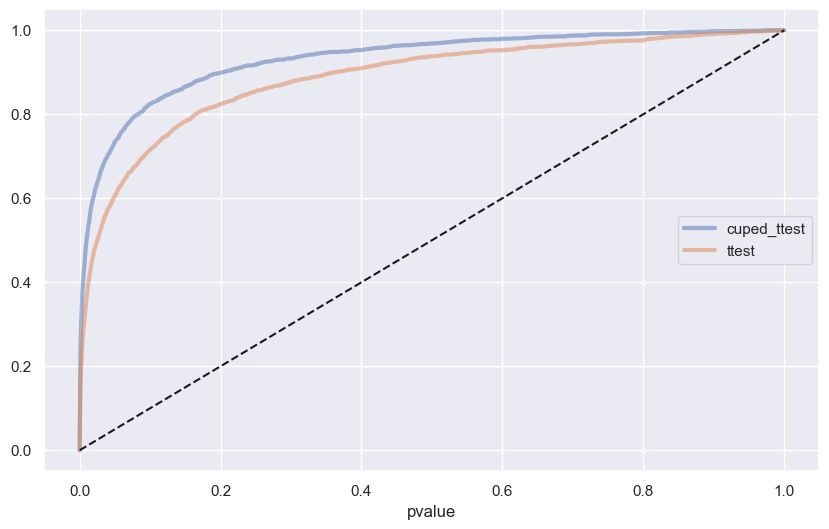

In [119]:
plt.figure(figsize=(10, 6))
X = np.linspace(0, 1, 1000)
for pvalues, title in zip(reversed(list_pvalues), reversed(list_titles)):
    pvalues = np.array(pvalues)
    Y = [np.mean(pvalues < x) for x in X]
    plt.plot(X, Y, alpha=0.5, linewidth=3, label=title)
plt.xlabel('pvalue')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc=5)
plt.show()